<a href="https://colab.research.google.com/github/baleineindigo/Statistic/blob/main/%EA%B8%B0%EC%A0%80%ED%95%A8%EC%88%98%EC%99%80_%EA%B3%BC%EC%B5%9C%EC%A0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.api as sm
import matplotlib.font_manager as fm
import scipy as sp
from statsmodels.datasets.longley import load_pandas


# # GPU 설정 : 런타임 > 런타임 유형 변경 > GPU
# # GPU 사용 가능한지 확인
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

## 기저함수 모형
데이터가 비선형일  때 선형회귀모형은 적합하지 않음.
이 때 독립변수 벡터 x를 입력으로 가지는 여러개의 비선형 함수로 원래의 입력 변수 x를 대체할 변수로 사용하고, 새로운 모형을 도입하면 성능을 개선할 수 있다.

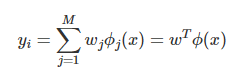

이 새로운 모형의 모수의 갯수는 원래의 독립변수의 갯수가 아니라 우리가 생각해 낸 비선형 함수의 갯수에 의존한다.

하지만 이러한 비선형 모형을 만들기 위해서는 데이터에 적합한 비선형 함수를 충분히 많이 생각해 낼 수 있어야 한다. 이러한 고충을 덜기 위해 만들어진 것이 기저함수(basis function) 모형이다. 기저함수는 특정한 규칙에 따라 만들어지는 함수의 열(sequence)로서 충분히 많은 수의 함수가 있으면 어떤 모양의 함수라도 비슷하게 흉내낼 수 있는 것을 말한다.


In [ ]:
# 비선형 함수
def make_nonlinear(seed=0):
    np.random.seed(seed)
    n_samples = 30
    X = np.sort(np.random.rand(n_samples))
    Y = np.sin(2 * np.pi * X) + np.random.randn(n_samples) * 0.1
    X = X[:, np.newaxis]
    return (X, Y)
# print(X,Y)
X, Y = make_nonlinear()
plt.scatter(X,Y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("비선형 데이터의 예")
plt.show()

### 다항 기저함수

기저함수 중 가장 간단한 것이 다항 기저함수(polynomial basis function)이다.

ϕ0(x)=1,ϕ1(x)=x,ϕ2(x)=x2,ϕ3(x)=x3,⋯
다항회귀(polynomial regression)는 다항 기저함수를 사용하는 기저함수 모형이다. 따라서 종속 변수와 독립 변수의 관계는 다음과 같이 표현할 수 있다.

y=w0+w1x+w2x2+…+wMxM
기저함수는 사람이 하나씩 생각해내는 것이 아니라 미리 만들어진 규칙에 의해 자동으로 생성되므로 비선형 함수를 만들기 위해 고민할 필요가 없다.

In [ ]:
phi0=np.polynomial.Polynomial.basis(1)
phi1=np.polynomial.Polynomial.basis(1)
phi2=np.polynomial.Polynomial.basis(2)
phi3=np.polynomial.Polynomial.basis(3)

x=np.linspace(-1,1,100)
print(x,len(x))

plt.plot(x,phi0(x),label="d=0")
plt.plot(x,phi1(x),label="d=1")
plt.plot(x,phi2(x),label="d=2")
plt.plot(x,phi3(x),label="d=3")
plt.legend()
plt.title("기본 다항 기저함수")
plt.show()

In [ ]:
'''
기저함수중에서도 서로 다른 두 기저함수의 곱의 정적분 값이 0이 되면 
직교기저함수(orthogonal basis function)라고 한다. 
체비세프 다항식은 직교기저함수의 한 예다.
'''
phi0=np.polynomial.chebyshev.Chebyshev.basis(0)
phi1=np.polynomial.chebyshev.Chebyshev.basis(1)
phi2=np.polynomial.chebyshev.Chebyshev.basis(2)
phi3=np.polynomial.chebyshev.Chebyshev.basis(3)

x=np.linspace(-1,1,100)


plt.plot(x,phi0(x),label="d=0")
plt.plot(x,phi1(x),label="d=1")
plt.plot(x,phi2(x),label="d=2")
plt.plot(x,phi3(x),label="d=3")
plt.legend()
plt.title("체비세프 다항 기저함수")
plt.show()

### StatsModels를 이용한 다항회귀
StatsModels에서는 OLS 클래스의 from_formula 메서드를 사용하여 다항회귀를 할 수 있다.


In [ ]:
df_X=pd.DataFrame(X,columns=["x"])
df_C=sm.add_constant(df_X)
df_Y=pd.DataFrame(Y,columns=["y"])
df=pd.concat([df_X,df_Y],axis=1)

# OLS 모델링
model=sm.OLS.from_formula("y ~ x",data=df)
result=model.fit()
print(result.summary())


In [ ]:
print(sm.OLS.from_formula("y ~ x + I(x**2)", data=df).fit().summary())

In [ ]:
print(sm.OLS.from_formula("y ~ x + I(x**2) + I(x**3)", data=df).fit().summary())

In [ ]:
# 회귀 분석 결과 >> 그래프
def polyreg(degree,seed=0,ax=None):
    X,Y=make_nonlinear(seed)

    df_X=pd.DataFrame(X,columns=["x"])
    df_C=sm.add_constant(df_X)
    df_Y=pd.DataFrame(Y,columns=["y"])
    df=pd.concat([df_X,df_Y],axis=1)

    # OLS 모델링
    model_str="y ~ "
    for i in range(degree):
        if i ==0:
            prefix=""
        else:
            prefix=" + "
        model_str+=prefix+"I(x**{})".format(i+1)
    model=sm.OLS.from_formula(model_str,data=df)
    result=model.fit()

    if ax:
        ax.scatter(X,Y)
        xx=np.linspace(0,1,1000)
        df_X1=pd.DataFrame(xx[:,np.newaxis],columns=["x"])
        ax.plot(xx,result.predict(df_X1))
        ax.set_ylim(-2,2)
        ax.set_title("degree = {}, seed = {}".format(degree,seed))
        xlabel="\n".join(str(result.params).split("\n")[:-1])
        font = {'family': 'NanumGothicCoding', 'color':  'black', 'size': 10}
        ax.set_xlabel(xlabel, fontdict=font)
   
    return result

In [ ]:
ax1 = plt.subplot(131)
polyreg(1, ax=ax1)
ax2 = plt.subplot(132)
polyreg(2, ax=ax2)
ax3 = plt.subplot(133)
polyreg(3, ax=ax3)
plt.tight_layout()
plt.show()

### 과최적화
모형을 특정 샘플 데이터에 대해 과도하게 최적화하는 것을 과최적화(overfitting)이라고 한다.

과최적화는

1. 독립 변수 데이터 갯수에 비해 모형 모수의 수가 과도하게 크거나

2. 독립 변수 데이터가 서로 독립이 아닌 경우에 발생한다.

이러한 상황에서는 같은 조건에 대해 답이 복수개 존재할 수 있기 때문이다.

과최적화가 문제가 되는 이유는 다음과 같다.

1. 트레이닝에 사용되지 않은 새로운 독립 변수 값을 입력하면 오차가 커진다. (cross-validation 오차)

2. 샘플이 조금만 변화해도 가중치 계수의 값이 크게 달라진다. (추정의 부정확함)

다음 그림에서 과최적화가 발생하면 주어진 데이터가 아닌 다른 새로운 x 데이터가 들어올 때 오차가 커지는 것을 볼 수 있다.

In [ ]:
plt.figure(figsize=(8, 8))
ax1 = plt.subplot(131)
polyreg(10, ax=ax1)
ax2 = plt.subplot(132)
polyreg(20, ax=ax2)
ax3 = plt.subplot(133)
polyreg(30, ax=ax3)
plt.tight_layout()
plt.show()


In [ ]:
result_1=polyreg(10, ax=ax1)
print(result_1.summary2())

result_2=polyreg(20, ax=ax1)
print(result_2.summary2())

result_3=polyreg(30, ax=ax1)
print(result_3.summary2())



In [ ]:
# 또한 데이터가 조금만 달라져도 가중치 값이 크게 달라지는 것도 확인할 수 있다.
plt.figure(figsize=(8, 8))
ax1 = plt.subplot(131)
polyreg(20, seed=2, ax=ax1)
ax2 = plt.subplot(132)
polyreg(20, seed=4, ax=ax2)
ax3 = plt.subplot(133)
polyreg(20, seed=6, ax=ax3)
plt.tight_layout()
plt.show()

In [ ]:
result_1=polyreg(10, ax=ax1)
print(result_1.summary2())

result_2=polyreg(20, ax=ax1)
print(result_2.summary2())

result_3=polyreg(30, ax=ax1)
print(result_3.summary2())

